## DOM MODEL
blame: BANA7075 Group 1

In [8]:
#Run these seperately
#pip install mlflow
#pip install pandas
#pip install sklearn

In [116]:
#import modules and functions

import mlflow
from mlflow.models import infer_signature

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, r2_score, root_mean_squared_error

In [12]:
# Load the CSV from filepath

folder_path = r'C:\BANA7075 Final Project\csv Merged Data'  # or replace with your target folder

# Prefix you're looking for
prefix = 'hamilton'

files = os.listdir(folder_path)
csv_files = [f for f in files if f.startswith(prefix) and f.endswith('.csv')]

if csv_files:
    file_path = os.path.join(folder_path, csv_files[0])
    print(f"Loaded: {file_path}")
else:
    print("No matching CSV files found.")


Loaded: C:\BANA7075 Final Project\csv Merged Data\hamilton_zip_merge__hamilton_20250422_222639__redfin_20250422_222948__created_20250422_233455.csv


In [191]:
#Feature Engineering

#Load data
df = pd.read_csv(file_path)

#Define target and features
target = 'Estimated_Days_On_Market'  # replace with actual column name
planned_features = ['saleamount','Year Built', '# Bedrooms', '# Full Bathrooms','# Half Bathrooms','Acreage', 'Finished Square Footage', 'Basement Type','Estimated_Days_On_Market']
df = df.dropna(subset=planned_features) #drop incomplete rows
df = df.dropna(subset=[target]) #drop incomplete rows

df['Basement_Type']=df['Basement Type']
df['Bedrooms']=df['# Bedrooms']
df['FinSquareFootage']=df['Finished Square Footage']

current_year = 2025
df['AgeofHome'] = current_year - df['Year Built']

mean_age = df['AgeofHome'].mean()
std_dev_age = np.std(df['AgeofHome'])
df['Age_stability_score'] = np.exp(-((df['AgeofHome'] - mean_age)**2) / (2 * (1.5*std_dev_age**2)))
df['Age_stability_score'] = (df['Age_stability_score']-1)*-1



# - OUTLIERS FILTERS - ######################################################################################
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 2.0 * IQR
upper_bound = Q3 + 2.0 * IQR

# Filter the DataFrame
df = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]

Q1 = df['saleamount'].quantile(0.25)
Q3 = df['saleamount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Filter the DataFrame
df = df[(df['saleamount'] >= lower_bound) & (df['saleamount'] <= upper_bound)]
################################################################################################################

X = df.drop(columns=[target]) #drop the target row 
y = df[target] #create a y value with target column
#print(X.columns)


#Basement Type Encoded
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Fit and transform the column (needs to be 2D)
encoded = encoder.fit_transform(X[['Basement_Type']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Basement_Type']))
encoded_df.index = X.index
X = pd.concat([X.drop(columns=['Basement_Type']), encoded_df], axis=1)
#print(X.columns)
#Combine Bathrooms into one number
X['Bathrooms'] = X['# Full Bathrooms'] + ((X['# Half Bathrooms'])/2)

X['Basement_Type_Full_Basement']= X['Basement_Type_Full Basement'] 
X['Basement_Type_Full_Crawl'] = X['Basement_Type_Full Crawl'] 
X['Basement_Type_Part_Basement'] = X['Basement_Type_Part Basement']
X['Basement_Type_Part_Crawl'] = X['Basement_Type_Part Crawl']  

features = ['saleamount','AgeofHome', 'Bedrooms', 'Bathrooms','Acreage', 'FinSquareFootage', 'Basement_Type_Full_Basement', 'Basement_Type_Full_Crawl','Basement_Type_Part_Basement', 'Basement_Type_Part_Crawl']

X = X[features].select_dtypes(include='number')
print(features)
print(X)

['saleamount', 'AgeofHome', 'Bedrooms', 'Bathrooms', 'Acreage', 'FinSquareFootage', 'Basement_Type_Full_Basement', 'Basement_Type_Full_Crawl', 'Basement_Type_Part_Basement', 'Basement_Type_Part_Crawl']
     saleamount  AgeofHome  Bedrooms  Bathrooms  Acreage  \
0        550000       74.0       3.0        3.0    1.061   
5        470000       63.0       3.0        2.5    0.623   
13       306000       73.0       3.0        1.0    0.539   
15       370000       66.0       3.0        2.0    0.164   
16       310000       54.0       4.0        2.5    0.207   
..          ...        ...       ...        ...      ...   
689      113000       97.0       3.0        2.0    0.207   
691      644689       25.0       3.0        2.5    0.242   
692      310000       44.0       2.0        3.0    0.050   
694      735000       54.0       4.0        3.0    0.688   
695      603000       95.0       3.0        2.5    0.197   

     Basement_Type_Full_Basement  Basement_Type_Full_Crawl  \
0              

In [197]:
# features = ['Year Built 6', '# Bedrooms 8', '# Bathrooms 7','Acreage 4', 'Finished Square Footage 7', 'Basement Type_Full Basement 5', 'Basement Type_Full Crawl 3', 'Basement Type_None 3', 'Basement Type_Part Basement 3', 'Basement Type_Part Crawl 3']
print(X.shape[0])

366


In [192]:
#This is where the model models

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the model hyperparameters
params = {
    "criterion": 'squared_error',
    "splitter": 'best',
    "random_state": 42,
    "max_depth": 5,
    "min_samples_leaf": 10,
    'min_samples_split': 5,
}

#Create a pipeline: scale features and train a decision tree regressor
model = Pipeline(steps=[('regressor', DecisionTreeRegressor(**params))])

#Train the model
model.fit(X_train, y_train)

#Predict and evaluate
preds = model.predict(X_val)
mae = mean_absolute_error(y_val, preds)
rmse = root_mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'r_squared: {r2:.3f}','\n')

print(y_val)
print(preds)

Mean Absolute Error: 6.67
Root Mean Squared Error: 8.41
r_squared: 0.266 

401    43.0
59     65.0
32     48.0
611    40.0
96     61.0
       ... 
152    52.0
170    51.0
400    43.0
608    40.0
450    49.0
Name: Estimated_Days_On_Market, Length: 74, dtype: float64
[58.         66.07692308 51.8        54.28205128 51.39393939 66.07692308
 51.39393939 68.2        59.         54.28205128 64.2        64.7
 51.8        58.         54.28205128 51.39393939 51.8        64.7
 59.         59.         51.8        54.28205128 54.28205128 58.
 58.         51.8        58.         51.8        66.07692308 51.8
 51.39393939 51.39393939 58.         55.27272727 51.8        64.7
 51.39393939 68.2        55.27272727 64.7        58.         55.27272727
 51.8        54.28205128 68.2        64.7        58.         64.2
 51.8        58.         72.53846154 64.2        58.         58.
 64.2        58.         54.28205128 51.8        56.1875     58.
 51.39393939 51.8        55.27272727 59.         51.8        51

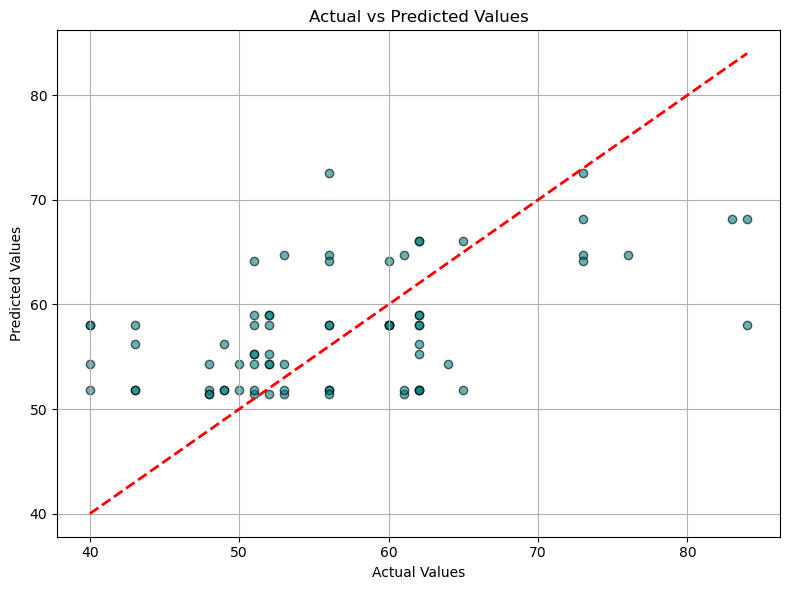

In [193]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_val, preds, alpha=0.6, color='teal', edgecolor='k')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()


# Manual Tuning for DEV ONLY

In [166]:
#regressor = DecisionTreeRegressor(max_depth=8, min_samples_leaf=2, random_state=42)
#
#model = Pipeline(steps=[('regressor', regressor)])
#
#model.fit(X_train, y_train)
#preds = model.predict(X_val)
#mae = mean_absolute_error(y_val, preds)
#print(f'Tuned MAE: {mae:.2f}')
#print(preds)

# Visualizer

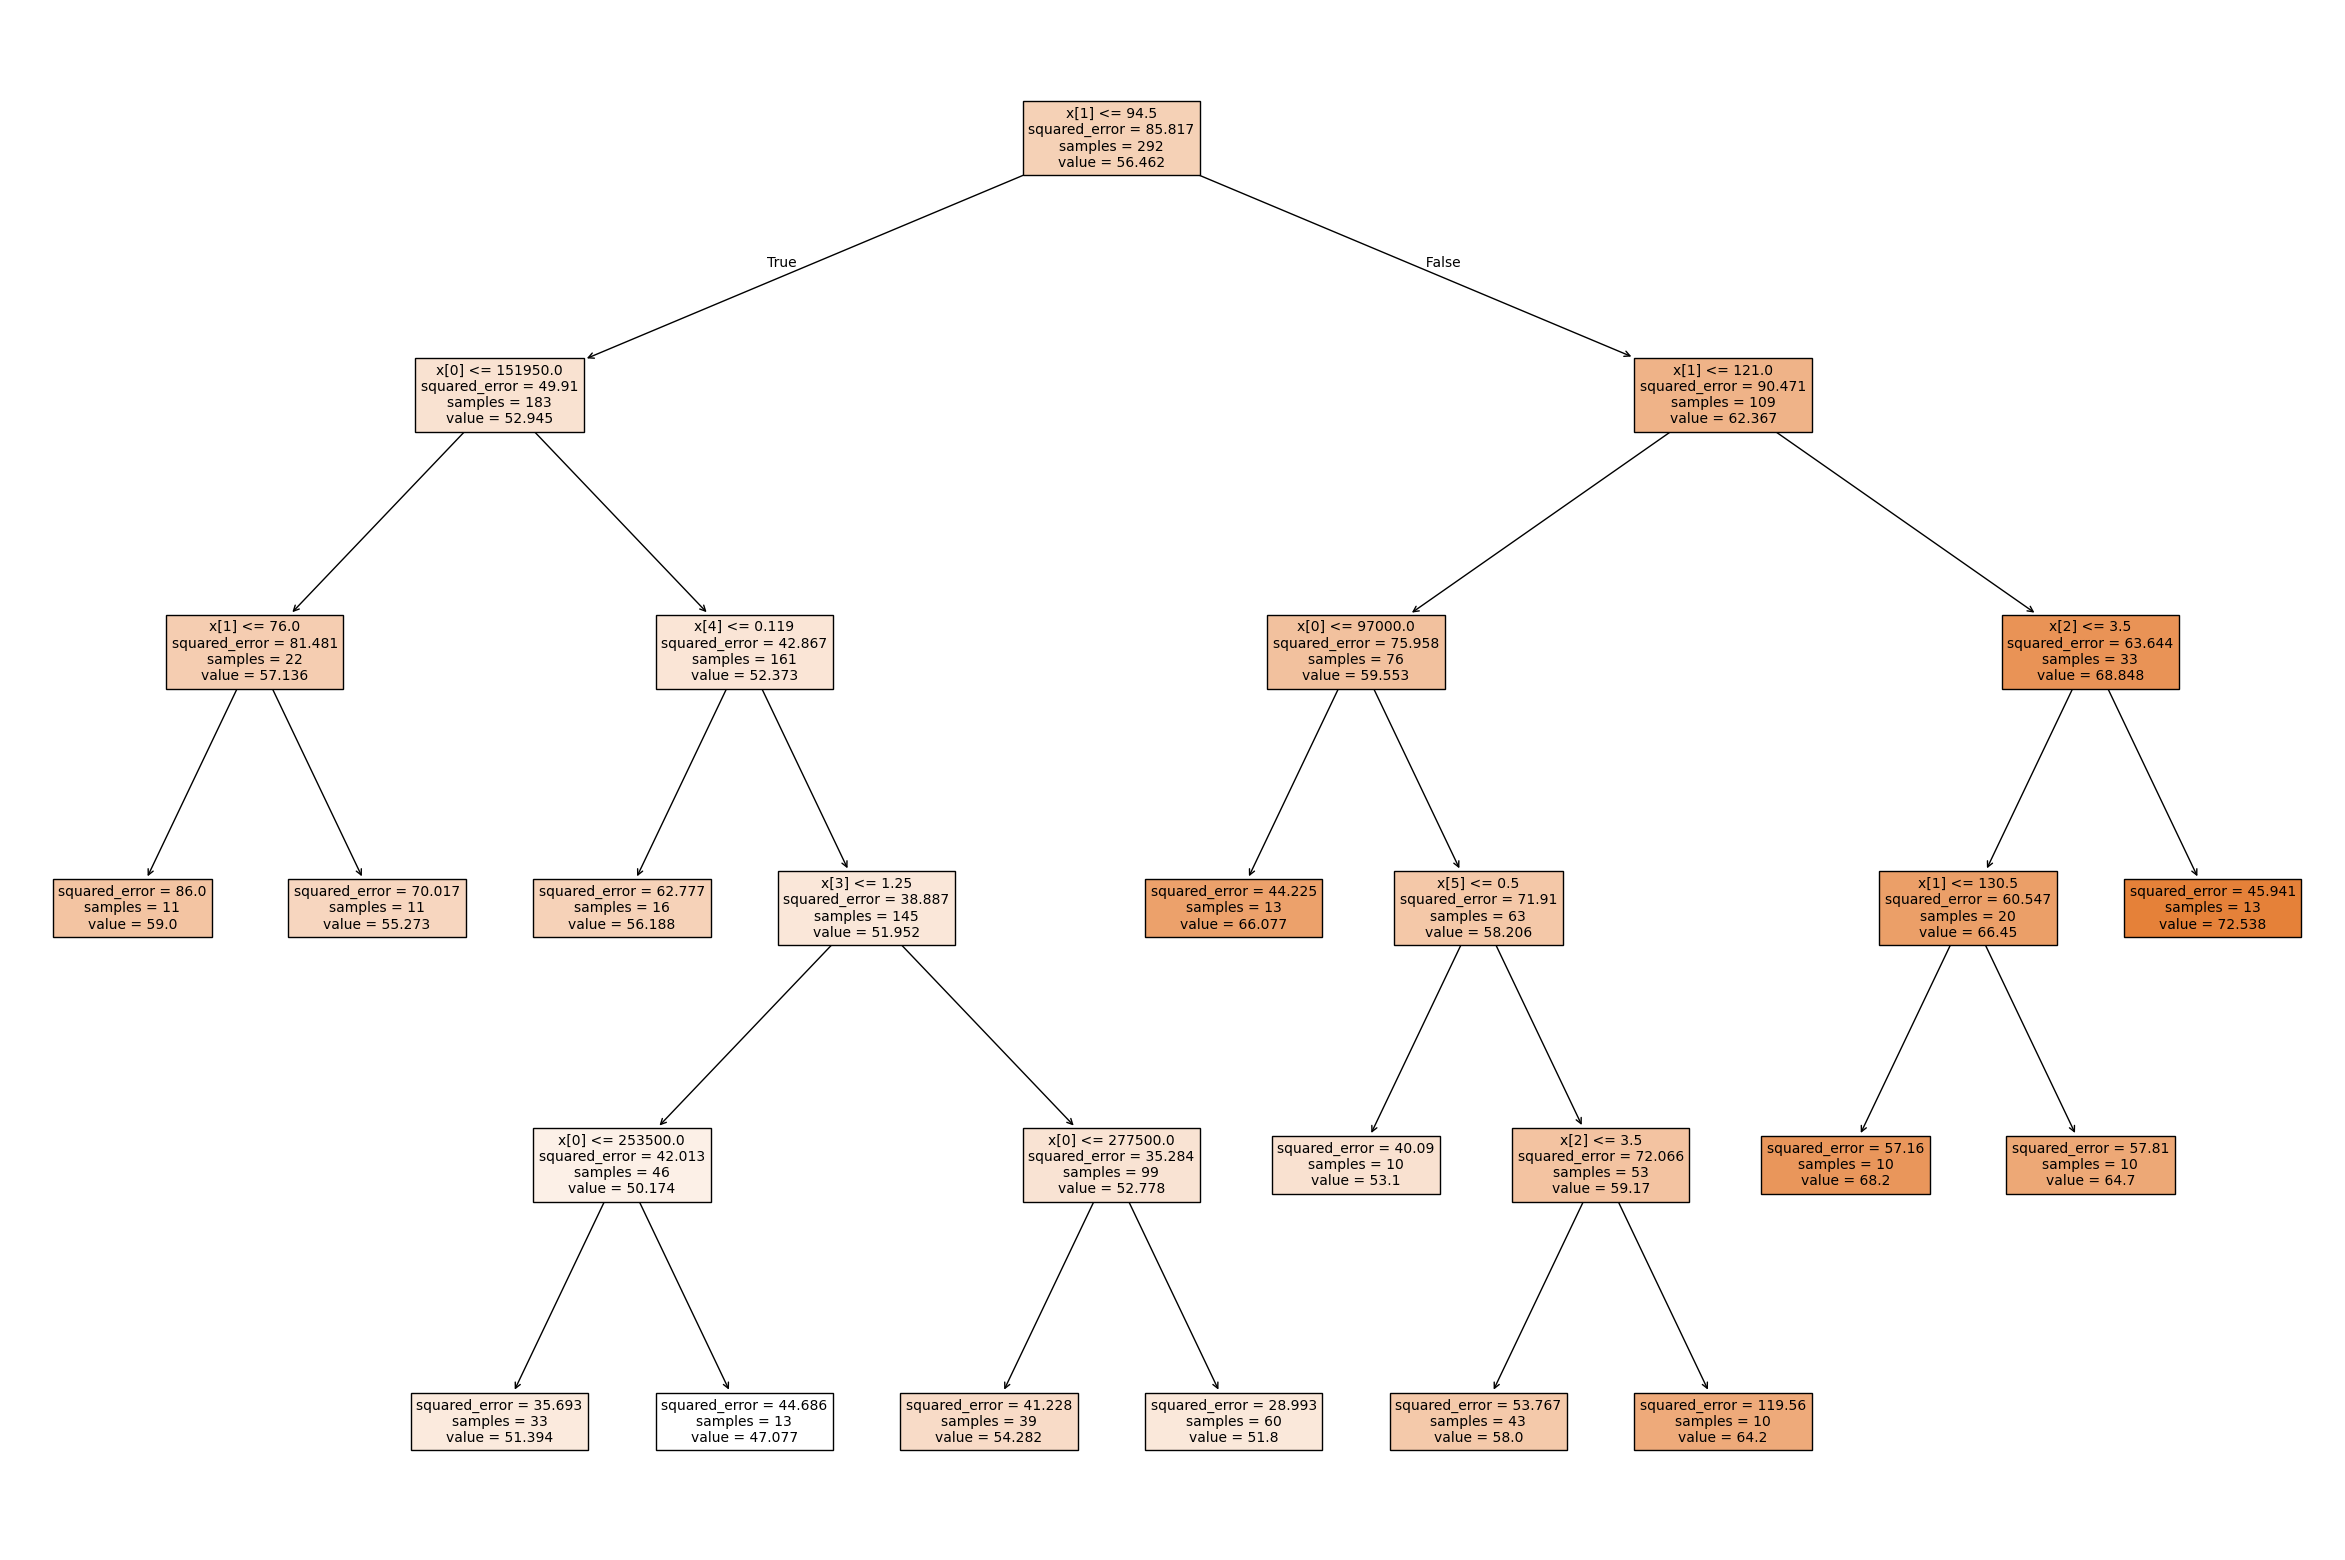

In [194]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the trained decision tree from the pipeline
regressor = model.named_steps['regressor']

# Plot it
plt.figure(figsize=(30,20))
plot_tree(
    regressor,
    filled=True,
    fontsize=10,
    max_depth=5  # limit depth for readability
)
plt.show()


# ML Flow Log

In [195]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

# Create a new MLflow Experiment
mlflow.set_experiment("Machine Learning Design Group 1")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("r_squared", r2)
    mlflow.log_metric("Mean Absolute Error", mae)
    mlflow.log_metric("Root Mean Squared Error", rmse)



    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("MVP", "First test of ML Flow with model")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="housing_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="DOM-predictor",
    )

C:\Users\schri\anaconda3\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Registered model 'DOM-predictor' already exists. Creating a new version of this model...
2025/04/23 13:01:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: DOM-predictor, version 4


🏃 View run amusing-hound-388 at: http://127.0.0.1:5000/#/experiments/939418381702007546/runs/532731c586984d17817769bdd6e25d28
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/939418381702007546


Created version '4' of model 'DOM-predictor'.


# Load the Model

In [190]:
# Load the model back for predictions as a generic Python Function model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

predictions = loaded_model.predict(X_val)

#iris_feature_names = datasets.load_iris().feature_names

result = pd.DataFrame(X_val, columns=features)
result["actual_class"] = y_val
result["predicted_class"] = predictions

result[:4]

,saleamount,AgeofHome,Age_stability_score,Bedrooms,Bathrooms,Acreage,FinSquareFootage,Basement_Type_Full_Basement,Basement_Type_Full_Crawl,Basement_Type_Part_Basement,Basement_Type_Part_Crawl,actual_class,predicted_class
401,265000,97.0,0.056578,2.0,2.0,0.100,NaN,1.0,0.0,0.0,0.0,43.0,58.000000
59,80000,96.0,0.048337,2.0,2.0,0.127,NaN,1.0,0.0,0.0,0.0,65.0,66.076923
32,575000,33.0,0.600955,4.0,2.5,0.629,NaN,1.0,0.0,0.0,0.0,48.0,52.079646
611,250000,58.0,0.213298,3.0,1.5,0.138,NaN,1.0,0.0,0.0,0.0,40.0,54.941176
